# SMFI Microscope Control GUI
Ben Jones 2022 (ben.jones@uta.edu)

In [1]:
import sys
import PyQt5
from PyQt5 import QtGui
from PyQt5.QtWidgets import  QApplication, QWidget, QPushButton, QVBoxLayout, QMessageBox, QLineEdit, QFormLayout,QLabel, QGridLayout, QCheckBox, QSlider
from PyQt5.QtCore import Qt, QTimer, QObject, QThread, pyqtSignal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
import scipy.stats as stats
from time import time, sleep
from scipy import optimize
from scipy.interpolate import interp2d


In [2]:
# Set this flag to true if you're running on the actual microscope computer
HARDWARE_ON=False

if(HARDWARE_ON):
    from Stage import Stage
    import CamHamPy

In [3]:
#Class that stores the camera settings

class CameraSettings:
    Gain=1
    Exposure=500
    EMCCD=False
    

#Class that stores field size settings for stage

class FieldSettings:
    XMin=-5
    XMax=5
    XStep=0.05

    YMin=-5
    YMax=5
    YStep=0.05

    ZMin=3.5
    ZMax=4.2
    ZStep=0.001
    
    XInit=1
    YInit=1
    ZInit=3.7
    
    ZSweepMin=3.7
    ZSweepMax=4.1
    ZSweepSteps=40



In [4]:

#These are fake objects that have the same interfaces as the camera and stage objects

class DummyCamera:
    def Snap(self, Exposure, GainMode, Gain):
        return(Gain*Exposure*np.random.rand(512,512))
    def Close():
        return
    
class DummyStage: 
    X=None
    Y=None
    Z=None


    def MoveToX(self,x):
        self.X=x

    def MoveToY(self,y):
        self.Y=y

    def MoveToZ(self,z):
        self.Z=z

    def MoveTo(self,x,y,z):
        self.MoveToX(x)
        self.MoveToY(y)
        self.MoveToZ(z)
            

In [5]:
# This worker object lives in its own thread and snaps images
# from the camera whenever 'go' in the dictionary is True.
        
class ImageStream(QObject):

    image=pyqtSignal(np.ndarray)
    stats=pyqtSignal(list)
    finished=pyqtSignal()
    CS=CameraSettings()

    MyCamera=None
    
    def __init__(self,camdict):
        super().__init__()
        self.MyCamera=camdict
    
    def run(self):
        while(True):
            if(self.MyCamera['go']==True):
                myimage = np.array(self.MyCamera['cam'].Snap(self.MyCamera['CS'].Exposure/1000, int(self.MyCamera['CS'].EMCCD), self.MyCamera['CS'].Gain))
                self.image.emit(myimage)

                mystats = [sum(sum(myimage)),
                        stats.kurtosis(np.ndarray.flatten(myimage))]
                self.stats.emit(mystats)
            sleep(self.MyCamera['CS'].Exposure/1000)




In [6]:
# Two classes that store the step history, 
# First in Z for this XY, and second in XY (and also focus info at selected points)

class ZHistory:
    Z=[]
    Intensity=[]
    Kurtosis=[]
    Time=[]
    
class THistory:
    X=[]
    Y=[]
    Focus={}

In [7]:


class MicroGui:

    # ===============
    # Internal variables
    # ===============
    
    HisZ = ZHistory()      # History of Z's and stats at this XY
    HisT = THistory()      # History of XY positions and focal points
    FS = FieldSettings()   # Field setting parameters
    
    AmZSweeping=False      # Are we mid Z-sweep?
    AmStreaming=False      # Are we streaming images from camera?
    ServosOn=True          # Are the servos on?

    FocalPlane=None        # Focal plane object, comes to life the >2 focal points found
    
    CurrentImage=np.array([[0,0],[0,0]])   # The most recent image
    
    #By putting this camera-related stuff into a dictionary it allows us to 
    # pass by reference to other threads.
    camdict={'cam':DummyCamera(),
            'CS':CameraSettings(),
            'go':False}
    
    
    
    #=================
    # Hooks to I/O
    #=================
    
    
    # A summy stage object (real one initiated in __init__)
    MyStage=DummyStage()
    
     
    # This starts the thread running for the camera acquisitions
    def SetupCameraThread(self):
        self.thread = QThread()
        self.worker=ImageStream(self.camdict)
        self.worker.moveToThread(self.thread)
        self.thread.started.connect(self.worker.run)
        self.worker.image.connect(self.updateimage)
        self.worker.stats.connect(self.updatestats)
        self.thread.start()
    
    # Camera thread calls back to this to update image and photo panel
    def updateimage(self,image):
        self.CurrentImage=image
        self.LastSnapTime=time()
        self.ax_photo.clear()
        self.ax_photo.imshow(self.CurrentImage)
        self.ax_photo.set_xticks([])
        self.ax_photo.set_yticks([])
        self.CanvasPhoto.draw()

    # Camera thread also calls back to this to update image states
    #   (computing done in secondary thread)
    def updatestats(self, stats):
        self.HisZ.Intensity.append(stats[0])
        self.HisZ.Kurtosis.append(stats[1])
        self.HisZ.Z.append(self.Z)
        self.HisZ.Time.append(self.LastSnapTime)  
        self.ZBestKurtosis=self.HisZ.Z[np.argmax(self.HisZ.Kurtosis)]
        self.ZBestIntensity=self.HisZ.Z[np.argmax(self.HisZ.Intensity)]
        if(self.AmStreaming==False):
            self.camdict['go']=False
        
        self.MakePosPlots()
            
        self.NextStageAction()
        self.NextCameraAction()

    # Switch the hardware camera on        
    def EnableCamera(self):
        self.camdict['cam']=CamHamPy.CamHamPy()

    # Switch the hardware camera off and go to dummy cam    
    def DisableCamera(self):
        self.camdict['cam'].Close()
        self.camdict['cam']=DummyCamera()
    
    # Switch on and calibrate the stage
    def EnableStage(self):
        self.MyStage=Stage(LastPos=False)
        self.MyStage.MoveTo(self.X,self.Y,self.Z)
    
    # Move the stage to new X,Y,Z
    def MoveTo(self, X,Y,Z):
        precision=4  # How many decimals to allow. hard-code for 4 for now.
        if(self.ServosOn):
            self.X=round(X,slprecision)
            self.Y=round(Y,precision)
            self.Z=round(Z,precision)
            
            if((self.X!=self.HisT.X[-1]) or (self.Y!=self.HisT.Y[-1])):
                self.HisT.X.append(self.X)
                self.HisT.Y.append(self.Y)
                if(len(self.HisZ.Z)>0):
                    self.ClearZHistory() 

        else:
            dlg = QDialog(self)
            dlg.setWindowTitle("Servos are off")
            dlg.setText("CANNOT MOVE WITH SERVOS OFF!")
            dlg.exec()

        self.UpdateAll()
        
        
    # ====================
    #. Tracking positions and focus
    # ====================
    
    
    # Clear the Z history (run at each move in X,Y)
    def ClearZHistory(self):
        self.HisZ.Z=[]
        self.HisZ.Intensity=[]
        self.HisZ.Kurtosis=[]
        self.HisZ.Time=[]

    # Create an extrapolated focal plane from focal points
    def DefineFocalPlane(self,xs,ys,zs):  
        def PlaneFunction(x,y, args):
            return args[0]*x + args[1]*y + args[2]
        Minimizefunction = lambda args: sum((zs-PlaneFunction(xs,ys, args))**2)
        res=optimize.minimize(Minimizefunction,[0,0,0])
        self.FocalPlane= lambda x,y: PlaneFunction(x,y, res.x)
        
    # ===================================
    #  Actions that can run in the event loop
    # ===================================
    
    #Placeholder actions (do nothing = default)            
    def NullCameraAction(self):
        return
    
    def NullStageAction(self):
        return
    
    # Advance to next image in sequence and save to disk
    def SequenceCameraAction(self):
        ImageID=int(self.StoreCount.text())
        if(ImageID>1):
            self.StoreCount.setText(str(ImageID-1))
            np.savetxt(self.StorePath.text()+"/im_" +str(self.ImagesToSave-ImageID)+".txt", self.CurrentImage)
        else:
            self.NextCameraAction=self.NullCameraAction
            self.Sequence.setText("Go")
            
    # Advance stage to next Z position
    def ZSweepStageAction(self):
        if(self.Z<self.FS.ZSweepMax):
            self.MoveTo(self.X,self.Y,self.Z+(self.FS.ZSweepMax-self.FS.ZSweepMin)/self.FS.ZSweepSteps)
        else:
            NextStageAction=self.NullStageAction
            self.AmZSweeping=False
            self.ZSweep.setText("Start ZSweep")
            
    
    #=========================
    # Making plots and UI updates
    # ========================
    
    
    # Updater called anytime the user does something interesting
    def UpdateAll(self):   
        self.UpdateUICoords(self.X,self.Y,self.Z)
        self.MakePosPlots()
    
    # Update all the X,Y,Z positions in the UI when any one is moved
    def UpdateUICoords(self,X,Y,Z):
        self.XText.setText(str(X))
        self.YText.setText(str(Y))
        self.ZText.setText(str(Z))
        self.XIs.setText(str(X))
        self.YIs.setText(str(Y))
        self.ZIs.setText(str(Z))
        self.XText.setText(str(X))
        self.YText.setText(str(Y))
        self.ZText.setText(str(Z))
        self.XSlide.setValue(int((X-self.FS.XMin)/self.FS.XStep))
        self.YSlide.setValue(int((Y-self.FS.YMin)/self.FS.YStep))
        self.ZSlide.setValue(int((Z-self.FS.ZMin)/self.FS.ZStep))
    

    # Make the XY and Z plots on the left panel
    def MakePosPlots(self):
        self.ax_xy.clear()
        self.ax_z[0].clear()
        self.ax_z[1].clear()
        
        self.ax_xy.set_xlim(self.FS.XMin,self.FS.XMax)
        self.ax_xy.set_ylim(self.FS.YMin,self.FS.YMax)
        self.ax_z[0].set_xlim(self.FS.ZMin,self.FS.ZMax)
        self.ax_z[1].set_xlim(self.FS.ZMin,self.FS.ZMax)
        self.ax_z[0].set_yticks([])
        self.ax_z[1].set_yticks([])
        self.ax_z[0].set_ylabel("Intensity")
        self.ax_z[1].set_ylabel("Kurtosis")

        if(self.FocalPlane!=None):
            X,Y=np.meshgrid(np.linspace(self.FS.XMin,self.FS.XMax,20),np.linspace(self.FS.YMin,self.FS.YMax,20))
            Z=self.FocalPlane(X,Y)
            self.ax_xy.contourf(X, Y, Z,cmap='RdBu',alpha=0.1,levels=100)
        
        self.ax_xy.plot([self.X],[self.Y],'o',color='red')
        if(len(self.HisT.X)>0):              
            self.ax_xy.plot(self.HisT.X,self.HisT.Y,color='dimgrey',alpha=0.3)
            FocXs=np.array(self.HisT.X)[list(self.HisT.Focus.keys())]
            FocYs=np.array(self.HisT.Y)[list(self.HisT.Focus.keys())]
            self.ax_xy.plot(FocXs,FocYs, 's',color='DarkBlue',markersize=2)

        if(len(self.HisZ.Z)>0):
            self.ax_z[0].plot(self.HisZ.Z,self.HisZ.Intensity,'.',color='DarkGreen')
            self.ax_z[1].plot(self.HisZ.Z,self.HisZ.Kurtosis,'.',color='DarkBlue')
            TopIntensity=np.max(self.HisZ.Intensity)
            TopKurtosis=np.max(self.HisZ.Kurtosis)

            BottomIntensity=np.min(self.HisZ.Intensity)
            BottomKurtosis=np.min(self.HisZ.Kurtosis)


            self.ax_z[0].plot([self.ZBestIntensity,self.ZBestIntensity],[BottomIntensity,TopIntensity],':',color='pink',linewidth=1)
            self.ax_z[1].plot([self.ZBestKurtosis,self.ZBestKurtosis],[BottomKurtosis,TopKurtosis],'--',color='pink',linewidth=1)
            self.ax_z[0].plot([self.Z,self.Z],[BottomIntensity,TopIntensity],color='DarkRed',linewidth=2)
            self.ax_z[1].plot([self.Z,self.Z],[BottomKurtosis,TopKurtosis],color='DarkRed',linewidth=2)

            self.ax_z[0].set_ylim(BottomIntensity,TopIntensity)
            self.ax_z[1].set_ylim(BottomKurtosis,TopKurtosis)  
                      
        self.CanvasObj.draw()
        self.CanvasObj2.draw()





    
    
    
    # =======================
    #   pyQT Widget functions 
    # =======================
    
    def on_stream_click(self):
        if(self.AmStreaming==False):
            self.AmStreaming=True
            self.Stream.setText("Stop Stream")
            self.camdict['go']=True
        else:
            self.Stream.setText("Stream")
            self.AmStreaming=False
            self.camdict['go']=False
        
    def on_one_click(self):
        AmStreaming=False
        self.camdict['go']=True

    def on_slider_move(self):
        self.MoveTo(self.FS.XMin+self.XSlide.value()*self.FS.XStep,
                    self.FS.YMin+self.YSlide.value()*self.FS.YStep,
                    self.FS.ZMin+self.ZSlide.value()*self.FS.ZStep)
        
    def on_textbox_edit(self):
        self.MoveTo(float(self.XText.text()),
                    float(self.YText.text()),
                    float(self.ZText.text()))
    
    def on_zsweep_click(self):
        if(self.AmZSweeping==False):
            self.ClearZHistory()
            self.MoveTo(self.X,self.Y,float(self.ZSweepMin.text()))
            self.NextStageAction=self.ZSweepStageAction
            self.FS.ZSweepMin=float(self.ZSweepMin.text())
            self.FS.ZSweepMax=float(self.ZSweepMax.text())
            self.FS.ZSweepSteps=float(self.ZSweepSteps.text())
            self.ZSweep.setText("Stop ZSweep")
            self.AmZSweeping=True
        else:
            self.NextStageAction=self.NullStageAction
            self.ZSweep.setText("Start ZSweep")
            self.AmZSweeping=False
    
    #Any camera setting change triggers this
    def on_cam_settings_change(self):
        self.camdict['CS'].EMCCD=self.CamEMCCD.isChecked()
        #try:    
        if(self.camdict['CS'].EMCCD==True):
            if(int(self.CamExposure.text())<27):
                self.camdict['CS'].Exposure=27
            elif(int(self.CamExposure.text())>10000):
                self.camdict['CS'].Exposure=10000
            else:
                try:
                    self.camdict['CS'].Exposure=int(self.CamExposure.text())
                except:
                    self.camdict['CS'].Exposure=500
        elif(self.camdict['CS'].EMCCD==False):
            if(int(self.CamExposure.text())<500):
                self.camdict['CS'].Exposure=500
            elif(int(self.CamExposure.text())>10000):
                self.camdict['CS'].Exposure=10000
            else:
                self.camdict['CS'].Exposure=int(self.CamExposure.text())

        if(self.camdict['CS'].EMCCD==False):
            self.camdict['CS'].Gain=1
        else:
            if(int(self.CamGain.text())<1):
                self.camdict['CS'].Gain=1
            elif(int(self.CamGain.text())>255):
                self.camdict['CS'].Gain=255
            else:
                self.camdict['CS'].Gain=int(self.CamGain.text())     
            
        self.CamExposure.setText(str(self.camdict['CS'].Exposure))
        self.CamGain.setText(str(self.camdict['CS'].Gain))
          
    # Switch servo / camera on and off
    def on_servo_change(self):
        if(self.ServosCheckBox.isChecked()==True):
            self.MyStage.EnableServos()
        elif(self.ServosCheckBox.isChecked()==False):
            self.MyStage.DisableServos()
            
    def on_camera_change(self):
        if(self.CameraCheckBox.isChecked()==True):
            self.EnableCamera()
        elif(self.CameraCheckBox.isChecked()==False):
            self.DisableCamera()
            
    # Autofocus buttons
    def on_autointensity(self):
        self.MoveTo(self.X,self.Y,self.ZBestIntensity)
        
    def on_autokurtosis(self):
        self.MoveTo(self.X,self.Y,self.ZBestKurtosis)
        
    # Start a sequence
    def on_sequence_go(self):
        if(self.Sequence.text()=="Go"):
            if(self.AmStreaming==False):
                self.on_stream_click()
            self.ImagesToSave=int(self.StoreCount.text())
            self.NextCameraAction=self.SequenceCameraAction
            self.Sequence.setText("Stop")
        else:
            self.StoreCount.setText(str(self.ImagesToSave))
            self.NextCameraAction=self.NullCameraAction
            self.Sequence.setText("Go")
    
    # Clear the focal point array
    def on_focusclear(self):
        self.HisT.Focus={}
        self.UpdateAll()

    #Move to extrapolated focal point
    def on_focusextrap(self):
        self.MoveTo(self.X,self.Y,self.FocalPlane(self.X,self.Y))

    #Add a focal point
    def on_focushere(self):
        self.HisT.Focus[len(self.HisT.X)-1]=self.Z
        
        #If there are at least 3 points, extrapolate a focal plane
        if(len(list(self.HisT.Focus.keys()))>2):
            FocXs=np.array(self.HisT.X)[list(self.HisT.Focus.keys())]
            FocYs=np.array(self.HisT.Y)[list(self.HisT.Focus.keys())]
            FocZs=list(self.HisT.Focus.values())
            self.DefineFocalPlane(FocXs,FocYs,FocZs)
        self.UpdateAll()
        
    # If user clicks the XY map, go there. 
    #  If we have a focal plane use it, otherwise stick at this Z.
    def on_map_press(self,event):    
        if(self.FocalPlane!=None):
            self.MoveTo(event.xdata,event.ydata,self.FocalPlane(event.xdata,event.ydata))
        else:
            self.MoveTo(event.xdata,event.ydata,self.Z)
  
                
    def on_zplot_press(self, event):
        self.Z1=round(event.xdata,self.precision)

        
    def on_zplot_release(self, event):
        if(event.button==1):
            self.Z2=round(event.xdata,self.precision)
            self.FS.ZMin=min(self.Z1,self.Z2)
            self.FS.ZMax=max(self.Z1,self.Z2)
            self.ZSweepMin.setText(str(self.FS.ZMin))
            self.ZSweepMax.setText(str(self.FS.ZMax))
        else:
            self.FS.ZMin=3.4
            self.FS.ZMax=4.1
            
        
    # ====================
    #  PyQt GUI Frames
    # ====================
    
    def SetupMoveFrame(self):
        self.MoveLayout = QGridLayout()

        self.XSlide=QSlider(orientation=Qt.Horizontal)
        self.XSlide.setRange(0, int((self.FS.XMax-self.FS.XMin)/self.FS.XStep))
        self.YSlide=QSlider(orientation=Qt.Horizontal)
        self.YSlide.setRange(0, int((self.FS.YMax-self.FS.YMin)/self.FS.YStep))
        self.ZSlide=QSlider(orientation=Qt.Horizontal)
        self.ZSlide.setRange(0, int((self.FS.ZMax-self.FS.ZMin)/self.FS.ZStep))
        
        self.XText=QLineEdit(text=str(self.FS.XInit))
        self.XText.editingFinished.connect(self.on_textbox_edit)
        self.YText=QLineEdit(text=str(self.FS.YInit))
        self.YText.editingFinished.connect(self.on_textbox_edit)
        self.ZText=QLineEdit(text=str(self.FS.ZInit))
        self.ZText.editingFinished.connect(self.on_textbox_edit)
        self.XSlide.sliderReleased.connect(self.on_slider_move)
        self.YSlide.sliderReleased.connect(self.on_slider_move)
        self.ZSlide.sliderReleased.connect(self.on_slider_move)    
        self.XIs=QLabel()
        self.YIs=QLabel()
        self.ZIs=QLabel()
        
        self.MoveLayout.addWidget(QLabel("Stage Control:"),1,0,1,3)
        self.MoveLayout.addWidget(QLabel("X"),2,0,1,1)
        self.MoveLayout.addWidget(self.XText,2,1,1,1)
        self.MoveLayout.addWidget(self.XIs,2,2,1,1)
        self.MoveLayout.addWidget(self.XSlide, 3,1,1,3)
        self.MoveLayout.addWidget(QLabel("Y"),4,0,1,1)
        self.MoveLayout.addWidget(self.YText,4,1,1,1)
        self.MoveLayout.addWidget(self.YIs,4,2,1,1)
        self.MoveLayout.addWidget(self.YSlide, 5,1,1,3)
        self.MoveLayout.addWidget(QLabel("Z"),6,0,1,1)
        self.MoveLayout.addWidget(self.ZText,6,1,1,1)
        self.MoveLayout.addWidget(self.ZIs,6,2,1,1)
        self.MoveLayout.addWidget(self.ZSlide,7,1,1,3)

 
        
    def SetupCamSettingsFrame(self):
        self.CamLayout= QFormLayout()
        self.CamLayout.addRow(QLabel("Camera Settings:"),QLabel(" "))
        self.CamGain=QLineEdit(text=str(self.camdict['CS'].Gain))
        self.CamExposure=QLineEdit(text=str(self.camdict['CS'].Exposure))
        self.CamEMCCD=QCheckBox()

        self.CamLayout.addRow(QLabel("Gain:"),self.CamGain)
        self.CamLayout.addRow(QLabel("Exposure:"),self.CamExposure)
        self.CamLayout.addRow(QLabel("EMCCD:"),self.CamEMCCD)

        self.CamGain.editingFinished.connect(self.on_cam_settings_change)
        self.CamExposure.editingFinished.connect(self.on_cam_settings_change)
        self.CamEMCCD.stateChanged.connect(self.on_cam_settings_change)
           
        
    def SetupActionsFrame(self):
        self.ActionsLayout= QGridLayout()
        self.ActionsLayout.addWidget(QLabel("Enable:"),1,0,1,3)
        
        
        self.ZSweep=QPushButton('Start ZSweep')
        self.ZSweep.clicked.connect(self.on_zsweep_click)
        self.ZSweepMin=QLineEdit(text=str(self.FS.ZSweepMin))
        self.ZSweepMax=QLineEdit(text=str(self.FS.ZSweepMax))
        self.ZSweepSteps=QLineEdit(text=str(self.FS.ZSweepSteps))
        
        self.ServosCheckBox=QCheckBox("Servos",checked=True)
        self.ServosCheckBox.stateChanged.connect(self.on_servo_change)
        
        self.CameraCheckBox=QCheckBox("Camera",checked=True)
        self.CameraCheckBox.stateChanged.connect(self.on_camera_change)
        
        self.AutoFocusKurtosis=QPushButton("Kurtosis")
        self.AutoFocusIntensity=QPushButton("Intensity")
        self.AutoFocusClear=QPushButton('Clear')
        self.AutoFocusKurtosis.clicked.connect(self.on_autokurtosis)
        self.AutoFocusIntensity.clicked.connect(self.on_autointensity)
        self.AutoFocusClear.clicked.connect(self.ClearZHistory)
        
        self.FocusHere=QPushButton('Record')
        self.FocusExtrap=QPushButton('Extrapolate')
        self.FocusClear=QPushButton('Clear')
        self.FocusHere.clicked.connect(self.on_focushere)
        self.FocusExtrap.clicked.connect(self.on_focusextrap)
        self.FocusClear.clicked.connect(self.on_focusclear)
        
        self.ActionsLayout.addWidget(self.ServosCheckBox,2,0,1,2)
        self.ActionsLayout.addWidget(self.CameraCheckBox,2,1,1,2)

        self.ActionsLayout.addWidget(QLabel("ZSweep:"),4,0,1,1)
        self.ActionsLayout.addWidget(self.ZSweep,5,0,1,2)
        self.ActionsLayout.addWidget(self.ZSweepMin,6,0,1,1)
        self.ActionsLayout.addWidget(self.ZSweepMax,6,1,1,1)
        self.ActionsLayout.addWidget(self.ZSweepSteps,6,2,1,1)
        
        self.ActionsLayout.addWidget(QLabel("AutoFocus:"),8,0,1,3)
        self.ActionsLayout.addWidget(self.AutoFocusIntensity,9,0,1,1)
        self.ActionsLayout.addWidget(self.AutoFocusKurtosis,9,1,1,1)
        self.ActionsLayout.addWidget(self.AutoFocusClear,9,2,1,1)
        
        self.ActionsLayout.addWidget(QLabel("Focal Plane:"),11,0,1,3)
        self.ActionsLayout.addWidget(self.FocusHere,12,0,1,1)
        self.ActionsLayout.addWidget(self.FocusExtrap,12,1,1,1)
        self.ActionsLayout.addWidget(self.FocusClear,12,2,1,1)

    def SetupCanvasFrame(self):
        self.FigLayout=QVBoxLayout()
        self.fig= plt.figure(figsize=(5,5),dpi=150)
        self.fig.add_axes(rect=[0,0,1,1])
        self.fig2= plt.figure(figsize=(5,5),dpi=150)
        self.fig2.add_axes(rect=[0,0,1,1])

        self.ax_xy=self.fig.get_axes()[0]
        gs = self.fig2.add_gridspec(2, hspace=0)
        self.ax_z = gs.subplots(sharex=True, sharey=False)
        
        self.CanvasObj=FigureCanvasQTAgg(self.fig)
        self.CanvasObj2=FigureCanvasQTAgg(self.fig2)
        #self.MakePosPlots()
        
        self.CanvasObj.mpl_connect("button_release_event", self.on_map_press)

        self.CanvasObj2.mpl_connect("button_press_event", self.on_zplot_press)        
        self.CanvasObj2.mpl_connect("button_release_event", self.on_zplot_release)
        
        
        self.FigLayout.addWidget(self.CanvasObj)
        self.FigLayout.addWidget(self.CanvasObj2)
        
    def SetupPhotoFrame(self):
        self.PhotoLayout=QGridLayout()
        
    
        self.photo= plt.figure(figsize=(5,5),dpi=200)
        self.photo.add_axes(rect=[0,0,1,1])
        self.ax_photo=self.photo.get_axes()[0]
        self.CanvasPhoto=FigureCanvasQTAgg(self.photo)
        self.PhotoLayout.addWidget(self.CanvasPhoto,1,0,8,4)
        
        self.Stream=QPushButton('Stream')
        self.Stream.clicked.connect(self.on_stream_click)        
        
        self.One=QPushButton('One')
        self.One.clicked.connect(self.on_one_click)        

        self.StoreCount=QLineEdit("100")
        self.StorePath=QLineEdit("./imgs/")
        self.Sequence=QPushButton("Go")
        
        self.Sequence.clicked.connect(self.on_sequence_go)
        

        self.PhotoLayout.addWidget(self.Stream,9,0,1,2)
        self.PhotoLayout.addWidget(self.One,9,2,1,2)
        
        self.PhotoLayout.addWidget(QLabel("Record sequence of:"),10,0,1,1)
        self.PhotoLayout.addWidget(self.StoreCount,11,0,1,1)
        self.PhotoLayout.addWidget(QLabel("into "),11,1,1,1)
        self.PhotoLayout.addWidget(self.StorePath,11,2,1,1)
        self.PhotoLayout.addWidget(self.Sequence,11,3,1,1)
        
    # ===================
    #  Initializer
    # ===================
    
    def __init__(self,HARDWARE_ON=True):

        # Start the history
        self.LastSnapTime=time()
        self.HisT.X=[self.FS.XInit]
        self.HisT.Y=[self.FS.YInit]
        
        # PyQt setup stuff
        self.app = QApplication([])
        self.window = QWidget()
        self.layout= QGridLayout()

        # Initiate all the GUI frames and make the layout
        self.SetupMoveFrame()   
        self.SetupCamSettingsFrame()
        self.SetupCanvasFrame()
        self.SetupCameraThread()
        self.SetupActionsFrame()
        self.SetupPhotoFrame()
    
        self.layout.addLayout(self.MoveLayout,1,0)
        self.layout.addLayout(self.CamLayout,2,0)
        self.layout.addLayout(self.FigLayout,1,1,3,1)
        self.layout.addLayout(self.ActionsLayout,3,0)
        self.layout.addLayout(self.PhotoLayout,1,2,3,1)
        
        # Install Null placeholder actions
        self.NextStageAction  = self.NullStageAction
        self.NextCameraAction = self.NullCameraAction
        
        # Move to the initial positions
        self.MoveTo(self.FS.XInit,
                  self.FS.YInit,
                  self.FS.ZInit)
        
        # Only if running on the real microscope computer....
        if(HARDWARE_ON):
            self.EnableCamera()
            self.EnableStage()
        
        #FLY, MY PRETTIES! AHAHAHA!
        self.window.setLayout(self.layout)
        self.window.show()
        self.app.exec()


/var/folders/0l/sqknt5xn1w3dx48zsbjg_7800000gn/T/ipykernel_43187/2650996398.py:195: UserWarning: Attempting to set identical left == right == 0.6794258373205742 results in singular transformations; automatically expanding.
  self.ax_z[0].set_xlim(self.FS.ZMin,self.FS.ZMax)
/var/folders/0l/sqknt5xn1w3dx48zsbjg_7800000gn/T/ipykernel_43187/2650996398.py:196: UserWarning: Attempting to set identical left == right == 0.6794258373205742 results in singular transformations; automatically expanding.
  self.ax_z[1].set_xlim(self.FS.ZMin,self.FS.ZMax)
/var/folders/0l/sqknt5xn1w3dx48zsbjg_7800000gn/T/ipykernel_43187/2650996398.py:229: UserWarning: Attempting to set identical bottom == top == 65496.63597033832 results in singular transformations; automatically expanding.
  self.ax_z[0].set_ylim(BottomIntensity,TopIntensity)
/var/folders/0l/sqknt5xn1w3dx48zsbjg_7800000gn/T/ipykernel_43187/2650996398.py:230: UserWarning: Attempting to set identical bottom == top == -1.1961612643978066 results in sin

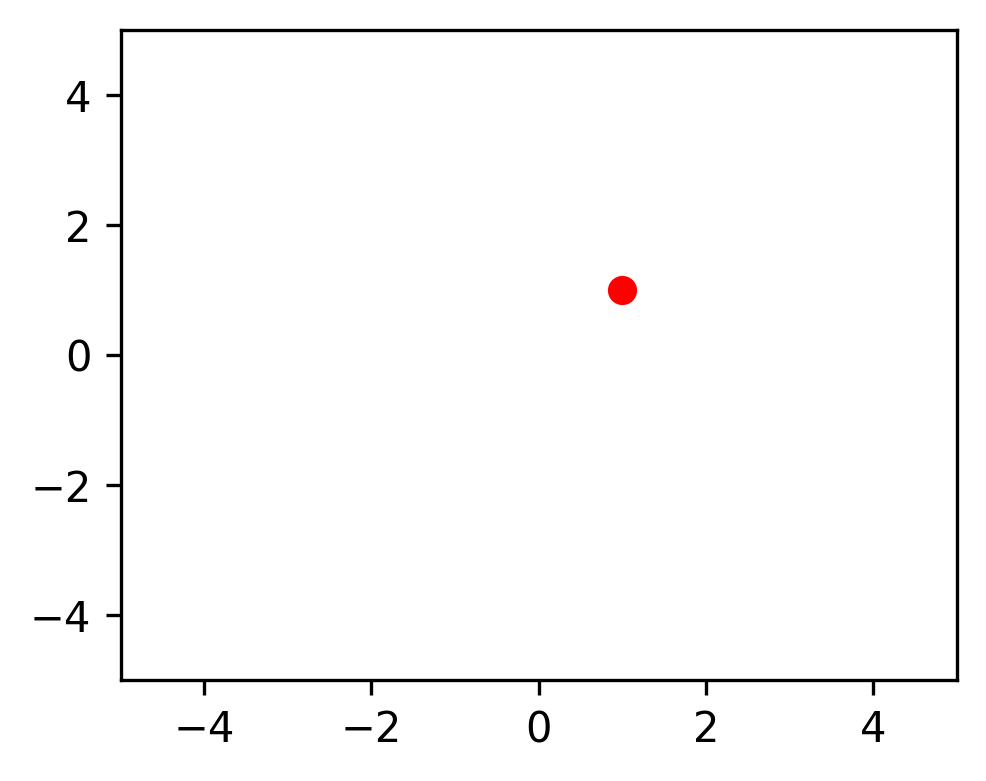

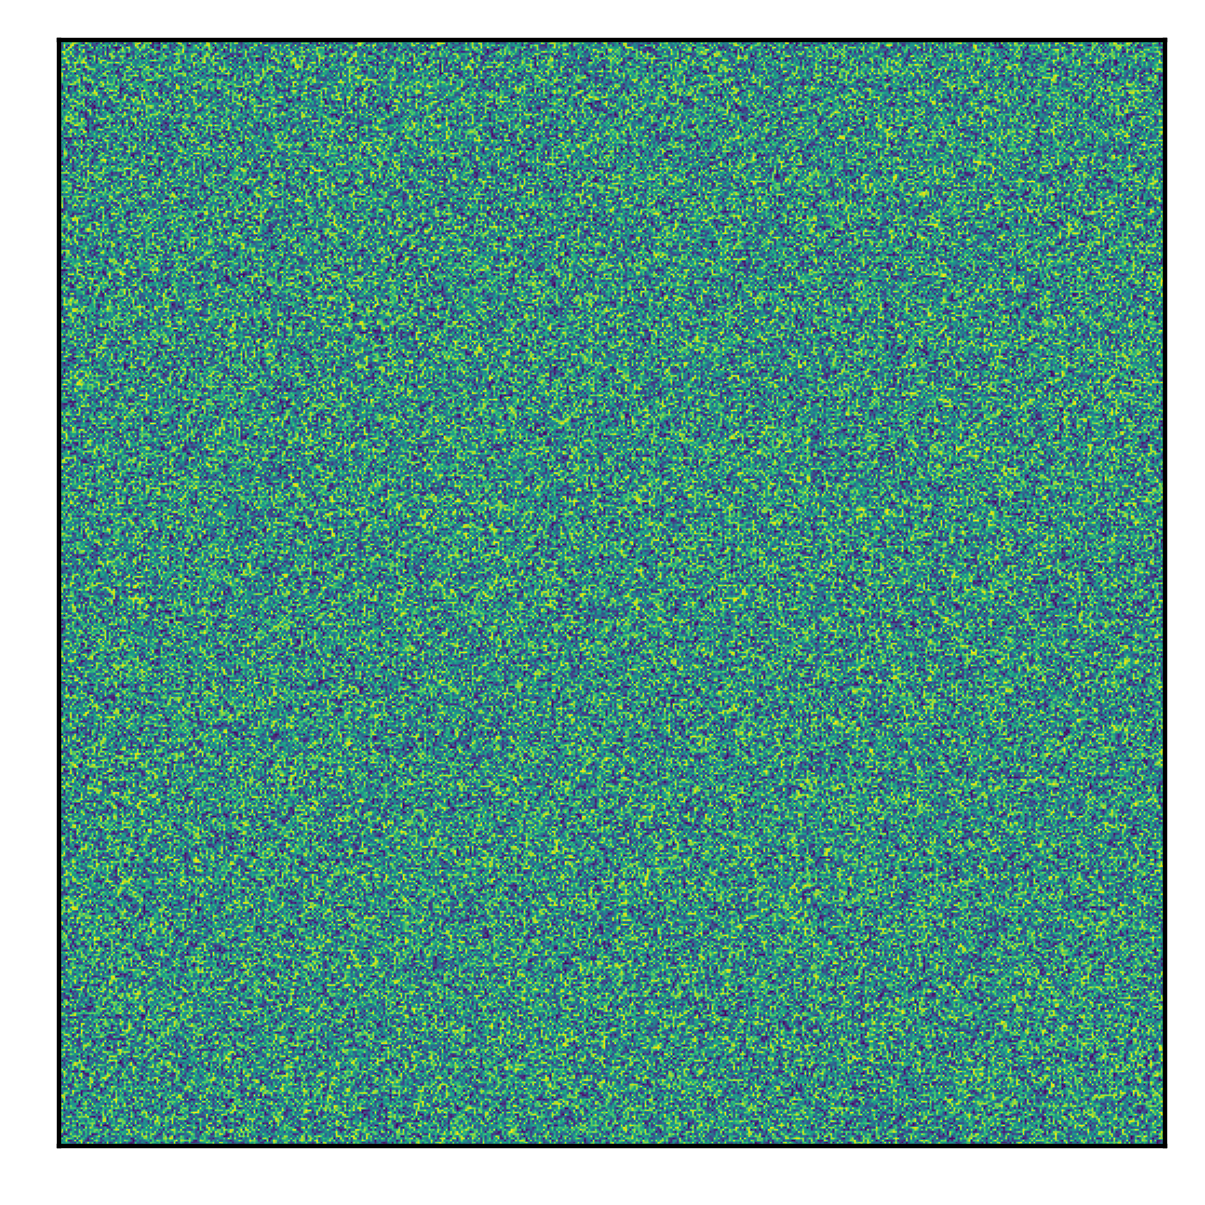

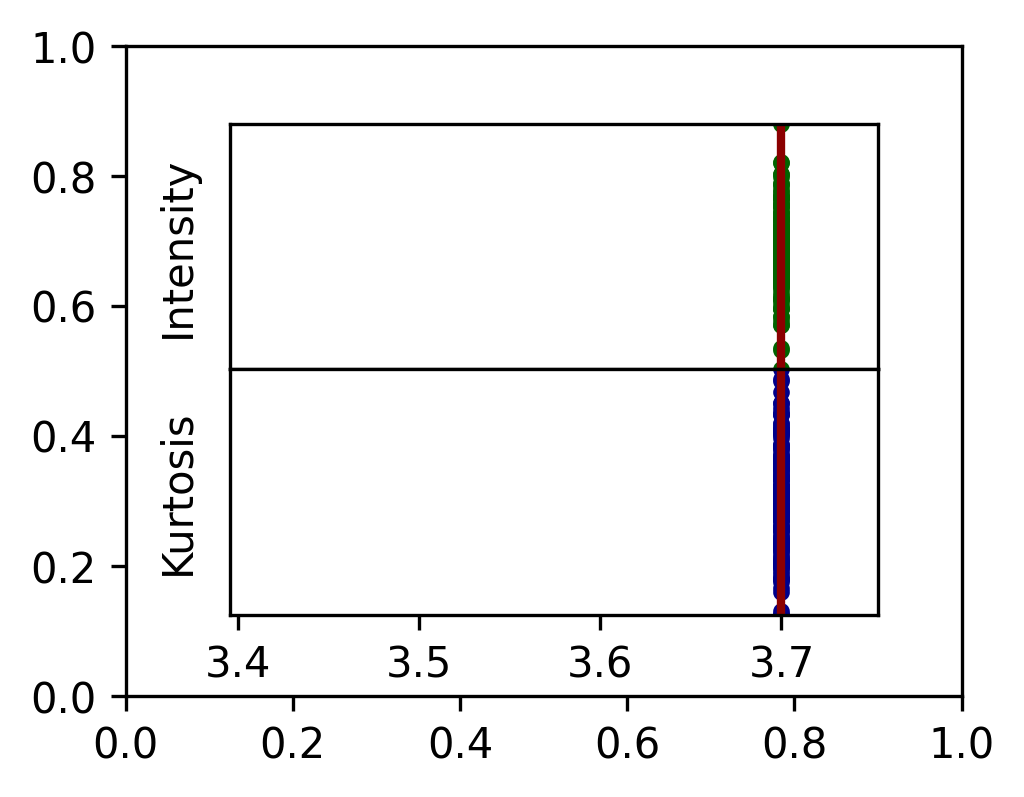

In [8]:
MicroGui(HARDWARE_ON)